In [1]:
# For exploring the datasets (jkhmmer, diamond outputs, AGP metadata, AGP filereports)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# For OLS
import statsmodels.formula.api as smf

In [3]:
concat_table = pd.read_csv('final_concat_table.tsv', sep='\t', index_col=0)

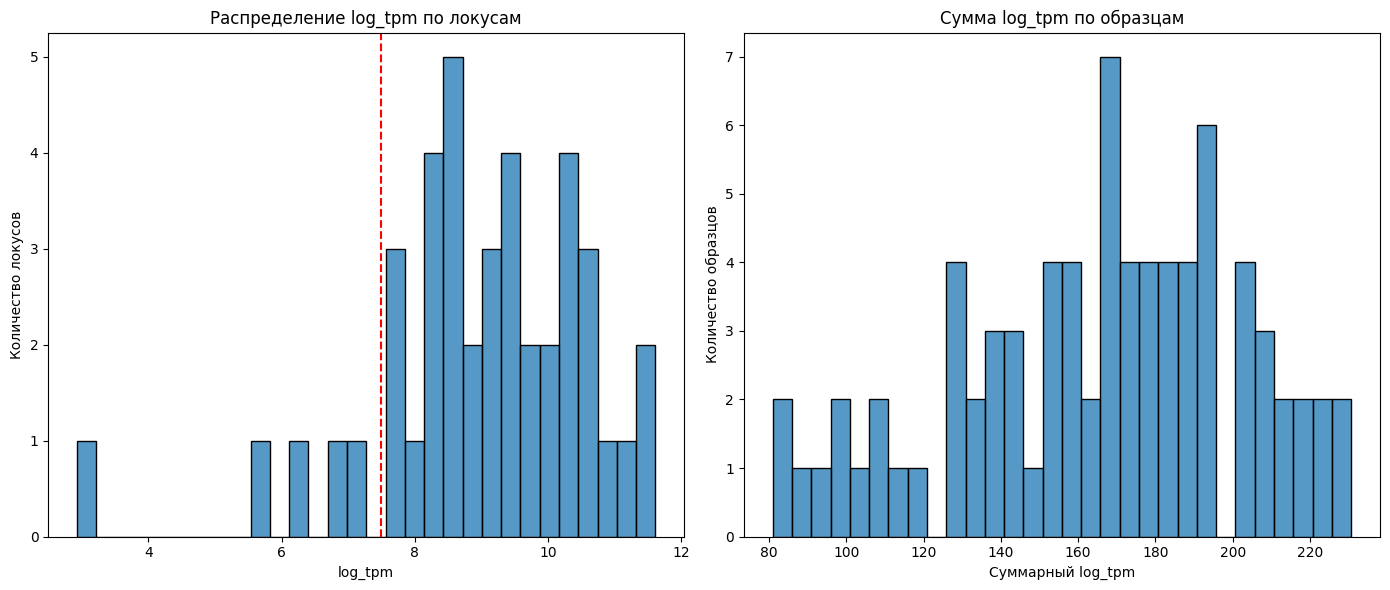

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Первая гистограмма — распределение log_tpm по локусам
locus_counts = (
    concat_table.groupby('locus')['log_tpm']
    .mean()
)
sns.histplot(locus_counts, ax=ax1, bins=30)
ax1.set_title('Распределение log_tpm по локусам')
ax1.set_xlabel('log_tpm')
ax1.axvline(x=7.5, color='red', ls='--')
ax1.set_ylabel('Количество локусов')

#Вторая гистограмма — распределение суммарного log_tpm по образцам
sample_sums = (
    concat_table.groupby('assemble')['log_tpm']
    .sum()
)
sns.histplot(sample_sums, ax=ax2, bins=30)
ax2.set_title('Сумма log_tpm по образцам')
ax2.set_xlabel('Суммарный log_tpm')
ax2.set_ylabel('Количество образцов')

plt.tight_layout()
plt.show()

In [29]:
concat_table_filter = concat_table[concat_table['log_tpm'] >= 6]

In [42]:
concat_table_sbc = concat_table[(concat_table['log_tpm'] >= 2) & (concat_table['log_tpm'] <= 11)]
concat_table_sbc.groupby(['Species', 'gastrointest_disord']).agg({'assemble':"nunique"})
# Для выбора референсного организма мы анализировали их предсталвенность среди кагорт пациентов.
# В качестве референс была выбрана s__Bacteroides caccae, представленная в обеих группах и значение TPM близко к среднему значению по выборке

assemble
Species                            gastrointest_disord          
s__Acutalibacter timonensis        Control                     2
                                   IBS                        10
s__Agathobacter rectalis           Control                     4
                                   IBS                         5
s__Bacteroides acidifaciens        Control                     7
                                   IBS                        10
s__Bacteroides caccae              Control                    29
                                   IBS                        32
s__Bacteroides ovatus              Control                     8
                                   IBS                         3
s__Bariatricus comes               Control                    18
                                   IBS                        21
s__Clostridium_A leptum            Control                     1
                                   IBS                         1
s__Clostridium_E jeddahense        IBS                         1
s__Dialister invisus               Control                    10
                                   IBS                        14
s__Enterocloster aldenensis        Control                     3
                                   IBS                         2
s__Enterocloster citroniae         IBS                         1
s__Escherichia coli_D              Control                     1
                                   IBS                         1
s__Faecalibacterium prausnitzii_I  Control                     2
                                   IBS                         5
s__Mediterraneibacter faecis       Control                    14
                                   IBS                        19
s__Megamonas funiformis            Control                     1
                                   IBS                         1
s__Murimonas intestini             IBS                         1
s__Phocaeicola coprocola           Control                     5
                                   IBS                         4
s__Phocaeicola dorei               Control                    37
                                   IBS                        39
s__Phocaeicola plebeius_A          Control                    14
                                   IBS                        19
s__Phocaeicola sartorii            Control                    23
                                   IBS                        20
s__Roseburia hominis               Control                    30
                                   IBS                        30
s__Ruthenibacterium lactatiformans Control                     8
                                   IBS                         8

In [31]:
def ols_model(df, name_bact):
    species_model = smf.ols(
        formula= f'log_tpm ~ gastrointest_disord * C(Species, Treatment(reference="{name_bact}")) + Host_age + host_body_mass_index + host_sex',
        data=concat_table_filter
    ).fit()

    df_out = species_model.summary2().tables[1]
    return df_out

In [32]:
def proc_table(df):
    table_filter = df[df['P>|t|'] < 0.05]    
    table_filter = table_filter.drop(['Intercept'],axis=0)
    
    df_index = list(table_filter.index)
    df_index_new = []
    
    for x in df_index:
        matches = re.findall(r'\[(.*?)\]', x)
        if matches:
            df_index_new.append(' | '.join(matches))
        else:
            df_index_new.append(x)
    table_filter.index = df_index_new
    return table_filter

In [33]:
def res_ols(df, name):
    plt.barh(df.index, df['Coef.'])
    plt.xticks()
    name_file = name
    name = ' '.join(name.split('_')[:2])
    plt.title(f'Refernce {name}')
    plt.xlabel("Coef.")
    plt.ylabel("Index")
    plt.tight_layout()

    plt.savefig(f'{name}.png')
    plt.show()

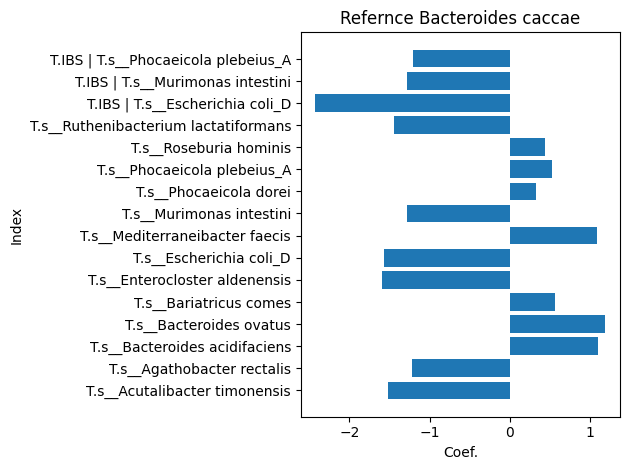

In [41]:
Bacteroides_caccae_table = ols_model(concat_table_filter, 's__Bacteroides caccae')
Bacteroides_caccae_table_filter = proc_table(Bacteroides_caccae_table)
res_ols(Bacteroides_caccae_table_filter, 'Bacteroides caccae')